# Titanic survivors prediction

#### Imports

In [373]:
# basic tools and visualization libs
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sb
from scipy import stats

# preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

import sklearn.metrics

from sklearn.model_selection import GridSearchCV 

#### Configurations

In [374]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('dark_background')
endDel = '\n\t' + '---'*15 + '\n'

#### 1. Data Exploration & Understanding

In [375]:
original_data = pd.read_csv("Data/train.csv", index_col="PassengerId")
original_data.info()

numericals = original_data[["Age", "SibSp", "Fare", "Parch"]]
categoricals = original_data[list(set(original_data.columns) - set(numericals))]
# SibSp: number of sibilings + spouses aboard
# Parch: number of parents + children aboard
# Pclass: Ticket class
# Embarked: Port of Embarkation	{ C = Cherbourg, Q = Queenstown, S = Southampton }
print(original_data.describe())
original_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.00

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### 2. Data Cleaning

In [376]:
original_data.dropna(subset=["Embarked", "Age"], inplace=True)
original_data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       529
Embarked      0
dtype: int64

#### 3. Exploration & Visualization

##### Distributions for numerical features

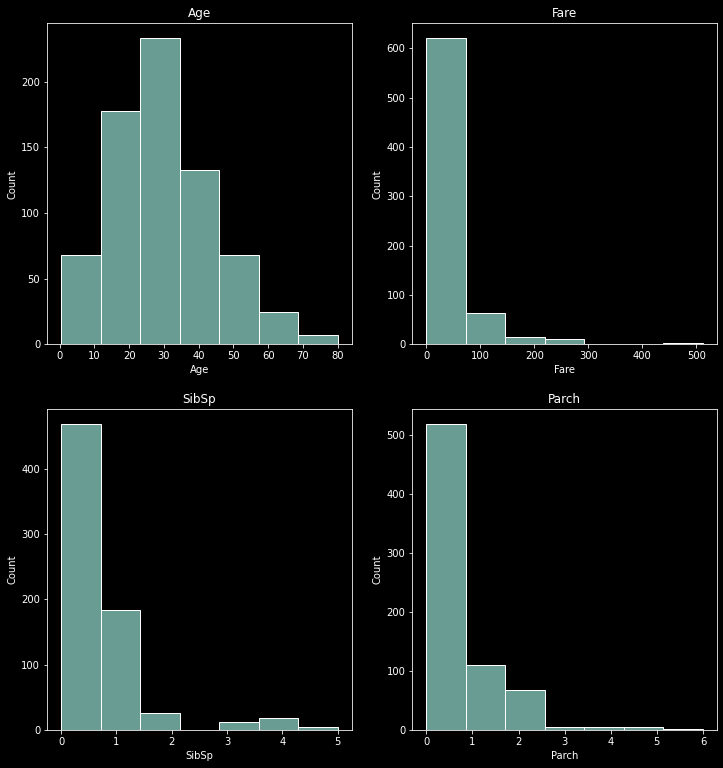

In [377]:
_, ax = plt.subplots(2, 2, figsize=(12, 13))
for i, n in enumerate(numericals):
    sb.histplot(data=original_data, ax=ax[i%2, 0 if i < 2 else 1], x=original_data[n], bins=7).set_title(n)

##### Correlation

            Age     SibSp      Fare     Parch
Age    1.000000 -0.308247  0.096067 -0.189119
SibSp -0.308247  1.000000  0.159651  0.414838
Fare   0.096067  0.159651  1.000000  0.216225
Parch -0.189119  0.414838  0.216225  1.000000


<AxesSubplot:>

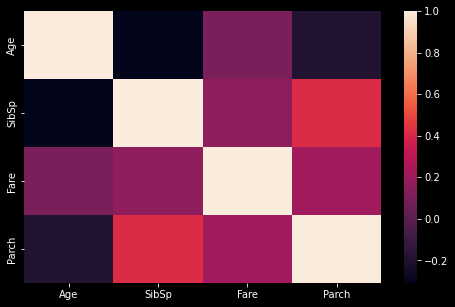

In [378]:
print(numericals.corr())
sb.heatmap(numericals.corr())

##### Categoricals barplots

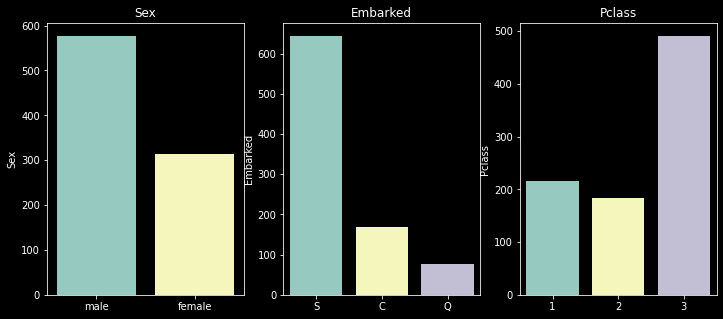

In [379]:
_, ax = plt.subplots(1, 3, figsize=(12, 5))
for i, c in enumerate(categoricals.drop(["Survived", "Ticket", "Cabin", "Name"], axis=1).columns):
    sb.barplot(ax=ax[i%3], x=categoricals[c].value_counts().index, y=categoricals[c].value_counts()).set_title(c)

##### Pivot Tables

In [380]:
print(pd.pivot_table(original_data, index="Survived", columns="Sex", values="Ticket", aggfunc="count"), end=endDel)
print(pd.pivot_table(original_data, index="Survived", columns="Embarked", values="Ticket", aggfunc="count"), end=endDel)
print(pd.pivot_table(original_data, index="Survived", columns="Pclass", values="Ticket", aggfunc="count"), end=endDel)
print(pd.pivot_table(original_data, index="Survived", values=numericals, aggfunc="mean"), end=endDel)

Sex       female  male
Survived              
0             64   360
1            195    93
	---------------------------------------------
Embarked   C   Q    S
Survived             
0         51  20  353
1         79   8  201
	---------------------------------------------
Pclass      1   2    3
Survived              
0          64  90  270
1         120  83   85
	---------------------------------------------
                Age       Fare     Parch     SibSp
Survived                                          
0         30.626179  22.965456  0.365566  0.525943
1         28.193299  51.647672  0.531250  0.496528
	---------------------------------------------


#### 4. Feature Engineering

In [381]:
# how many cabins for that particular person
original_data["Cabins_count"] = original_data.Cabin.apply(lambda x : 0 if pd.isna(x) else len(x.split(' ')))
print(pd.pivot_table(original_data, index="Survived", columns="Cabins_count", values="Ticket", aggfunc="count"), end=endDel)

# is cabin type related to survival rate
original_data["Cabin_letter"] = original_data.Cabin.apply(lambda x: str(x)[0].strip())
print(pd.pivot_table(original_data, index="Survived", columns="Cabin_letter", values="Name", aggfunc="count"), end=endDel)

# is person's title related to survival rate
original_data["Title"] = original_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
print(pd.pivot_table(original_data, index="Survived", columns="Title", values="Name", aggfunc="count"), end=endDel)

# keep numbers only in tickets
# original_data.Ticket = original_data.Ticket.apply(lambda x: x.split(' ')[-1]) (dropped)
# original_data.Ticket = original_data.Ticket.apply(lambda x: x if x.isnumeric() else 0) (dropped)

Cabins_count      0      1    2    3    4
Survived                                 
0             364.0   50.0  7.0  3.0  NaN
1             165.0  110.0  8.0  3.0  2.0
	---------------------------------------------
Cabin_letter    A     B     C     D     E    F    G    T      n
Survived                                                       
0             5.0  11.0  21.0   8.0   8.0  4.0  2.0  1.0  364.0
1             7.0  32.0  30.0  23.0  22.0  7.0  2.0  NaN  165.0
	---------------------------------------------
Title     Capt  Col  Don   Dr  Jonkheer  Lady  Major  Master   Miss  Mlle  \
Survived                                                                    
0          1.0  1.0  1.0  3.0       1.0   NaN    1.0    15.0   41.0   NaN   
1          NaN  1.0  NaN  3.0       NaN   1.0    1.0    21.0  104.0   2.0   

Title     Mme     Mr   Mrs   Ms  Rev  Sir  the Countess  
Survived                                                 
0         NaN  331.0  23.0  NaN  6.0  NaN           NaN  

#### 5. Data preprocessing for model

In [382]:
# Split features and target
x_train = original_data.drop(["Name", "Survived", "Cabin"], axis=1)
y_train = original_data["Survived"]

# Normalization
# np.log(x.SibSp+1).hist() (unused)
x_train.Fare = np.log(x_train.Fare+1)
x_train.head()

# ultimately decided to drop the ticket feature altogether
dummies = pd.get_dummies(x_train[["Sex", "Embarked", "Cabin_letter", "Title"]], drop_first=True)
x_train.drop(["Sex", "Embarked", "Cabin_letter", "Title", "Ticket"], axis=1, inplace=True)
x_train = pd.concat([x_train, dummies], axis=1)
# x_train.Ticket = x_train.Ticket.astype(float) (dropped)

cols_to_scale = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Cabins_count"]
scaler = MinMaxScaler()
x_train[cols_to_scale] = scaler.fit_transform(x_train[cols_to_scale])

x_test = x_train.sample(frac=0.2, random_state=1)
y_test = y_train.loc[x_test.index]
y_train = y_train.drop(y_test.index)
x_train = x_train.drop(x_test.index)

x_train.head()

,Pclass,Age,SibSp,Parch,Fare,Cabins_count,Sex_male,Embarked_Q,Embarked_S,Cabin_letter_B,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
PassengerId,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.472229,0.2,0.0,0.685892,0.25,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1.0,0.321438,0.0,0.0,0.350727,0.00,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,0.0,0.434531,0.2,0.0,0.639463,0.25,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
5,1.0,0.434531,0.0,0.0,0.352955,0.00,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
7,0.0,0.673285,0.0,0.0,0.635755,0.25,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0


#### 6. Basic models

In [383]:
# Naive Bayes
nb_model = GaussianNB()
nb_cv = cross_val_score(nb_model, x_train, y_train, cv=10)
print("Naive Bayes CV", nb_cv, nb_cv.mean(), sep='\n', end=endDel)

# Logistic Regression
lr_model = LogisticRegression(max_iter=2000)
lr_cv = cross_val_score(lr_model, x_train, y_train, cv=10)
print("Logistic Regression CV", lr_cv, lr_cv.mean(), sep='\n', end=endDel)

# Decision Tree
dt_model = tree.DecisionTreeClassifier(random_state=1)
dt_cv = cross_val_score(dt_model, x_train, y_train, cv=10)
print("Decision Tree CV", dt_cv, dt_cv.mean(), sep='\n', end=endDel)

# Support Vector Machine
svc_model = SVC(probability=True)
svc_cv = cross_val_score(svc_model, x_train, y_train, cv=10)
print("Support Vector Machine CV", svc_cv, svc_cv.mean(), sep='\n', end=endDel)

# K Nearest Neighbour
knn_model = KNeighborsClassifier()
knn_cv = cross_val_score(knn_model, x_train, y_train, cv=10)
print("K Nearest Neighbour CV", knn_cv, knn_cv.mean(), sep='\n', end=endDel)

Naive Bayes CV
[0.68421053 0.75438596 0.73684211 0.68421053 0.40350877 0.70175439
 0.78947368 0.77192982 0.8245614  0.71929825]
0.7070175438596491
	---------------------------------------------
Logistic Regression CV
[0.85964912 0.75438596 0.84210526 0.87719298 0.80701754 0.85964912
 0.80701754 0.78947368 0.84210526 0.8245614 ]
0.8263157894736842
	---------------------------------------------
Decision Tree CV
[0.73684211 0.70175439 0.77192982 0.73684211 0.75438596 0.80701754
 0.73684211 0.68421053 0.78947368 0.78947368]
0.7508771929824561
	---------------------------------------------
Support Vector Machine CV
[0.84210526 0.78947368 0.84210526 0.84210526 0.8245614  0.80701754
 0.77192982 0.71929825 0.85964912 0.85964912]
0.8157894736842104
	---------------------------------------------
K Nearest Neighbour CV
[0.85964912 0.8245614  0.84210526 0.85964912 0.85964912 0.80701754
 0.84210526 0.75438596 0.87719298 0.80701754]
0.8333333333333334
	---------------------------------------------


#### 7. Ensemble models

In [384]:
# Gradient Boost
xgb_model = XGBClassifier(random_state =1)
xgb_cv = cross_val_score(xgb_model, x_train, y_train,cv=10)
print("Gradient Boost CV", xgb_cv, xgb_cv.mean(), sep='\n', end=endDel)

# Random forest
rf_model = RandomForestClassifier(random_state=1)
rf_cv = cross_val_score(rf_model, x_train, y_train, cv=10)
print("Random forest CV", rf_cv, rf_cv.mean(), sep='\n', end=endDel)

# Voting classifier
voting_clf = VotingClassifier(estimators=[("nb_model", nb_model), ("lr_model", lr_model), ("dt_model", dt_model), ("svc_model", svc_model),
("knn_model", knn_model), ("rf_model", rf_model), ("xgb_model", xgb_model)], voting = "soft")
 
vc_cv = cross_val_score(voting_clf, x_train, y_train, cv=10)
print("Voting Classifier CV", vc_cv, vc_cv.mean(), sep='\n', end=endDel)

Gradient Boost CV
[0.78947368 0.73684211 0.80701754 0.87719298 0.8245614  0.85964912
 0.8245614  0.77192982 0.87719298 0.87719298]
0.8245614035087719
	---------------------------------------------
Random forest CV
[0.75438596 0.73684211 0.84210526 0.87719298 0.78947368 0.80701754
 0.78947368 0.75438596 0.84210526 0.84210526]
0.8035087719298245
	---------------------------------------------
Voting Classifier CV
[0.84210526 0.73684211 0.84210526 0.85964912 0.80701754 0.84210526
 0.8245614  0.75438596 0.87719298 0.85964912]
0.8245614035087719
	---------------------------------------------


#### 8. Models grid search

##### Logistic Regression

In [385]:
# Logitic regression
lr_gs = GridSearchCV(lr_model, param_grid = {
    'max_iter' : [2000, 4000, 6000],
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']},
    cv = 10, verbose = 1, n_jobs = -1).fit(x_train, y_train)
print('best score:', lr_gs.best_score_)
print('best parameters:', lr_gs.best_params_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
best score: 0.8298245614035087
best parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}


##### KNN

In [386]:
# KNN
knn_gs = GridSearchCV(knn_model, param_grid = {
    'n_neighbors' : [3,5,7,9],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree','kd_tree'],
    'p' : [1,2]},
    cv = 10, verbose = 1, n_jobs = -1).fit(x_train, y_train)
print('best score:', knn_gs.best_score_)
print('best parameters:', knn_gs.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
best score: 0.8350877192982455
best parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


##### SVC

In [387]:
# SVC
svc_gs = GridSearchCV(svc_model, param_grid = [
    {
        'kernel': ['rbf'], 
        'gamma': [0.1, .5, 1, 5, 10],
        'C': [0.1, 1, 10, 100]
    },
    {
        'kernel': ['linear'], 
        'C': [0.1, 1, 10, 100]
    },
    {
        'kernel': ['poly'], 
        'degree' : [2, 3],
        'C': [0.1, 1, 10, 100]
    }],
    cv = 10, verbose = 1, n_jobs = -1).fit(x_train, y_train)
print('best score:', svc_gs.best_score_)
print('best parameters:', svc_gs.best_params_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
best score: 0.8280701754385964
best parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


##### Random Forest

In [388]:
# Random forest
rf_gs = GridSearchCV(rf_model, param_grid = {
    'n_estimators': [400, 500, 550],
    'criterion':['gini', 'entropy'],
    'bootstrap': [True],
    'max_depth': [15, 20],
    'max_features': ['sqrt', 10],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 3]},
    cv = 10, verbose = True, n_jobs = -1).fit(x_train, y_train)
print('best score:', rf_gs.best_score_)
print('best parameters:', rf_gs.best_params_)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
best score: 0.8333333333333333
best parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}


##### XGB

In [389]:
# XGB
xgb_gs = GridSearchCV(xgb_model, param_grid = {
    'n_estimators': [450, 500],
    'colsample_bytree': [0.75, 0.8],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6],
    'learning_rate':[0.5],
    'gamma':[.5, 1],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']},
    cv = 5, verbose = True, n_jobs = -1).fit(x_train, y_train)
print('best score:', xgb_gs.best_score_)
print('best parameters:', xgb_gs.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
best score: 0.8456140350877194
best parameters: {'colsample_bytree': 0.75, 'gamma': 0.5, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 450, 'reg_alpha': 1, 'reg_lambda': 10, 'sampling_method': 'uniform', 'subsample': 0.55}


#### 9. Models Testing

In [390]:
models = {
    "xgb_gs": xgb_gs,
    "rf_gs": rf_gs,
    "svc_gs": svc_gs,
    "knn_gs": knn_gs,
    "lr_gs": lr_gs 
}

def test_model(model_name, model):
    print(model_name, model.score(x_test, y_test), end=endDel)

for k, v in models.items():
    test_model(k, v)

xgb_gs 0.7676056338028169
	---------------------------------------------
rf_gs 0.7746478873239436
	---------------------------------------------
svc_gs 0.7887323943661971
	---------------------------------------------
knn_gs 0.7605633802816901
	---------------------------------------------
lr_gs 0.8028169014084507
	---------------------------------------------


#### 10. Submission

##### Preprocessing

In [391]:
test_data = pd.read_csv("Data/test.csv", index_col="PassengerId").astype({"Ticket": str})

test_data["Cabins_count"] = test_data.Cabin.apply(lambda x : 0 if pd.isna(x) else len(x.split(' ')))
test_data["Cabin_letter"] = test_data.Cabin.apply(lambda x: str(x)[0].strip())
test_data["Title"] = test_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

test_data.Fare = np.log(test_data.Fare+1)
test_data.Sex = test_data.Sex.map({"male": 0, "female":1})
test_data[scaler.feature_names_in_] = scaler.transform(test_data[scaler.feature_names_in_])

test_data = test_data.drop(["Name", "Cabin", "Ticket"], axis=1)

test_data = pd.concat([test_data, pd.get_dummies(test_data[["Sex", "Embarked", "Cabin_letter", "Title"]], drop_first=True)], axis=1)
test_data.drop(["Sex", "Embarked", "Cabin_letter", "Title"], axis=1, inplace=True)

# print(set(test_data.columns)-set(x_train.columns)) # in test but not in train
# print(set(x_train.columns)-set(test_data.columns)) # in train but not in test
test_data = test_data.reindex(columns = x_train.columns, fill_value=0) # removes extra cols and adds missing ones

# Filling NA with mean
test_data.isna().sum()
test_data.Age.fillna(x_train.Age.mean(), inplace=True)
test_data.Fare.fillna(x_train.Fare.mean(), inplace=True)

test_data.head()

,Pclass,Age,SibSp,Parch,Fare,Cabins_count,Sex_male,Embarked_Q,Embarked_S,Cabin_letter_B,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,1.0,0.428248,0.0,0.000000,0.348997,0.0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
893,1.0,0.585323,0.2,0.000000,0.333195,0.0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
894,0.5,0.773813,0.0,0.000000,0.379604,0.0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
895,1.0,0.334004,0.0,0.000000,0.363449,0.0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
896,1.0,0.271174,0.2,0.166667,0.414494,0.0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


##### Submission

In [392]:
def save_submission(model_name, model):
    submission = pd.DataFrame(data={'PassengerId': test_data.index, 'Survived': model.predict(test_data)})
    submission.to_csv("Submissions/"+model_name+"_submission.csv", index=False)

for k, v in models.items():
    save_submission(k, v)